In [152]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats
import re
import seaborn as sns
from sklearn.model_selection import KFold
import scipy.stats

In [153]:
results_0_90 = []
results_0_20 = []
results_correlation_coefficient = []

In [154]:
def extract_parameters(filename):
    # Define the pattern to extract the parameters from the filename
    pattern = r'zh_(\d+)to(\d+)_b([\d.]+)_z_MCMAC.txt'
    
    # Search for the pattern in the filename
    match = re.search(pattern, filename)
    
    if match:
        # Extract the parameters
        param1 = match.group(1)
        param2 = match.group(2)
        b_value = match.group(3)
        
        # Format the parameters as "1:1 (b=0)"
        formatted_params = f"{param1}:{param2} (b={b_value})"
        
        return formatted_params
    else:
        return None

def pp_plot(data1, data2):
    # Sort both data sets
    ecdf1 = np.sort(data1)
    ecdf2 = np.sort(data2)
    
    # Calculate cumulative probabilities
    p1 = np.arange(1, len(ecdf1)+1) / len(ecdf1)
    p2 = np.arange(1, len(ecdf2)+1) / len(ecdf2)
    
    # Interpolate to find corresponding probabilities in the second data set
    p2_interp = np.interp(ecdf1, ecdf2, p2)
    
    # Plot P-P plot
    plt.figure(figsize=(8, 6))
    plt.plot(p1, p2_interp, 'o', label='Data')
    plt.plot([0, 1], [0, 1], 'r--', label='Ideal')
    plt.xlabel('Cumulative Probability (Data1)')
    plt.ylabel('Cumulative Probability (Data2)')
    plt.title('P-P Plot')
    plt.legend()
    plt.grid(True)
    plt.show()

def bland_altman_plot(data1, data2, *args, **kwargs):
    data1 = np.asarray(data1)
    data2 = np.asarray(data2)
    mean = np.mean([data1, data2], axis=0)
    diff = data1 - data2
    md = np.mean(diff)
    sd = np.std(diff, axis=0)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(mean, diff, *args, **kwargs, label='Data Points', alpha=0.6)
    plt.axhline(md, color='gray', linestyle='--', label='Mean Difference')
    plt.axhline(md + 1.96*sd, color='red', linestyle='--', label='95% Limit of Agreement (+)')
    plt.axhline(md - 1.96*sd, color='red', linestyle='--', label='95% Limit of Agreement (-)')
    
    plt.xlabel('Mean of MCMAC and Catalog Data')
    plt.ylabel('Difference between MCMAC and Catalog Data')
    plt.title('Bland-Altman Plot')
    plt.legend()
    plt.show()



def plotImage(filename_default, zoom_x_range, zoom_y_range, plot1_x_range, plot1_y_range, plot2_x_range, plot2_y_range, plot3_x_range, plot3_y_range, absolute_merge_time):
    df_default = pd.read_csv(filename_default, sep='\t')
    df_selected_default = df_default[['age','sep.kpc','merger', 'delta.t', 'TSC0', 'TSC0.lower', 'TSC0.upper']]
    df_selected_default['TSC0_2sigma.lower'] = df_selected_default['TSC0'] - 2 * np.abs(df_selected_default['TSC0'] - df_selected_default['TSC0.lower'])
    df_selected_default['TSC0_2sigma.upper'] = df_selected_default['TSC0'] + 2 * np.abs(df_selected_default['TSC0.upper'] - df_selected_default['TSC0'])

    # When we replace Time Till Collision to Time Since Collision, we need to set minus.
    # We got Time Till Collision by using MCMAC-pre code.
    df_selected_default.loc[df_selected_default['merger'] == 'pre', ['TSC0', 'TSC0.lower', 'TSC0.upper', 'TSC0_2sigma.lower', 'TSC0_2sigma.upper']] *= -1

    # 相対誤差の計算
    df_selected_default = df_selected_default.copy()
    df_selected_default.loc[:, 'Absolute Residual'] = df_selected_default['TSC0'] - df_selected_default['delta.t']
    # df_selected_default.loc[:, 'Absolute Residual'] = df_selected_default['TSC0'] - df_selected_default['delta.t']


    # 'merger'が'pre'の場合と'post'の場合でそれぞれの条件をチェック
    pre_condition = df_selected_default[(df_selected_default['merger'] == 'pre') & 
                                        ((df_selected_default['delta.t'] <= df_selected_default['TSC0_2sigma.lower']) & 
                                        (df_selected_default['delta.t'] >= df_selected_default['TSC0_2sigma.upper']))]

    post_condition = df_selected_default[(df_selected_default['merger'] == 'post') & 
                                        ((df_selected_default['delta.t'] >= df_selected_default['TSC0_2sigma.lower']) & 
                                        (df_selected_default['delta.t'] <= df_selected_default['TSC0_2sigma.upper']))]

    # 'pre' と 'post' のすべての行が条件を満たしているかチェック
    if len(pre_condition) == len(df_selected_default[df_selected_default['merger'] == 'pre']) and \
    len(post_condition) == len(df_selected_default[df_selected_default['merger'] == 'post']):
        print("2σ covers it")
    else:
        print("2σ does not cover it")
        
        # 'pre' の条件を満たしていない行を表示
        pre_violation = df_selected_default[(df_selected_default['merger'] == 'pre') & 
                                            ~((df_selected_default['delta.t'] >= df_selected_default['TSC0_2sigma.lower']) & 
                                            (df_selected_default['delta.t'] <= df_selected_default['TSC0_2sigma.upper']))]
        if not pre_violation.empty:
            print("The following 'pre' data points do not cover delta.t within the 2σ range:")
            print(pre_violation[['age', 'TSC0_2sigma.lower', 'delta.t', 'TSC0_2sigma.upper']])
        
        # 'post' の条件を満たしていない行を表示
        post_violation = df_selected_default[(df_selected_default['merger'] == 'post') & 
                                            ~((df_selected_default['delta.t'] >= df_selected_default['TSC0_2sigma.lower']) & 
                                            (df_selected_default['delta.t'] <= df_selected_default['TSC0_2sigma.upper']))]
        if not post_violation.empty:
            print("The following 'post' data points do not cover delta.t within the 2σ range:")
            print(post_violation[['age', 'TSC0_2sigma.lower', 'delta.t', 'TSC0_2sigma.upper']])
    # プロットスタイルの設定
    plt.style.use('ggplot')

    # 図とグリッドスペックの作成
    fig = plt.figure(figsize=(12, 18))
    gs = gridspec.GridSpec(4, 1, height_ratios=[1, 1, 1, 2])

    # delta.t の範囲でフィルタリング
    df_zoomed = df_selected_default[(df_selected_default['delta.t'] >= -0.3) & (df_selected_default['delta.t'] <= 0.3)]

    # 最上部プロット (拡大図)
    ax_zoom = fig.add_subplot(gs[0])
    line_zoom2 = ax_zoom.errorbar(df_zoomed['delta.t'], df_zoomed['TSC0'], yerr=[np.abs(df_zoomed['TSC0'] - df_zoomed['TSC0.lower']), np.abs(df_zoomed['TSC0.upper'] - df_zoomed['TSC0'])], fmt='o', ecolor='red', capsize=5, markersize=6, color='red', label='TSC from MCMAC', zorder=3)
    line_zoom3 = ax_zoom.errorbar(df_zoomed['delta.t'], df_zoomed['TSC0'], yerr=[np.abs(df_zoomed['TSC0'] - df_zoomed['TSC0_2sigma.lower']), np.abs(df_zoomed['TSC0_2sigma.upper'] - df_zoomed['TSC0'])], fmt='o', ecolor='blue', capsize=5, markersize=6, color='red', label='TSC from MCMAC 2σ', zorder=4)
    line_zoom1 = ax_zoom.scatter(df_zoomed['delta.t'], df_zoomed['delta.t'], label='TSC from Catalog', color='black', s=64, marker='^', zorder=5)


    # 縦の点線を追加
    ax_zoom.axvline(color='black', linestyle='--', zorder=1)
    ax_zoom.axhline(color='black', linestyle='--', zorder=2)


    ax_zoom.set_xlabel('delta.t (TSC from catalogue)')
    ax_zoom.set_ylabel('TSC from Catalog')
    ax_zoom.set_xlim(zoom_x_range[0], zoom_x_range[1])
    ax_zoom.set_ylim(zoom_y_range[0], zoom_y_range[1])

    # 二つ目のy軸としてTSC from MCMACを追加
    ax_zoom2 = ax_zoom.twinx()
    ax_zoom2.set_ylabel('TSC from MCMAC')
    ax_zoom2.set_ylim(zoom_y_range[0], zoom_y_range[1])

    lines_zoom = [line_zoom2, line_zoom1,line_zoom3 ]
    labels_zoom = [l.get_label() for l in lines_zoom]
    ax_zoom.legend(lines_zoom, labels_zoom, loc='upper left')

    # 上部プロット
    ax1 = fig.add_subplot(gs[1])
    ax2 = ax1.twinx()
    line1 = ax1.scatter(df_selected_default['age'], df_selected_default['delta.t'], label='TSC from Catalog', color='black', s=64, marker='^', zorder=10)
    line2 = ax2.errorbar(df_selected_default['age'], df_selected_default['TSC0'], yerr=[np.abs(df_selected_default['TSC0'] - df_selected_default['TSC0.lower']), np.abs(df_selected_default['TSC0.upper'] - df_selected_default['TSC0'])], fmt='o', ecolor='red', capsize=5, markersize=6, color='red', label='TSC from MCMAC', zorder=-1)
    line3 = ax2.errorbar(df_selected_default['age'], df_selected_default['TSC0'], yerr=[np.abs(df_selected_default['TSC0'] - df_selected_default['TSC0_2sigma.lower']), np.abs(df_selected_default['TSC0_2sigma.upper'] - df_selected_default['TSC0'])], fmt='o', ecolor='blue', capsize=5, markersize=6, color='red', label='TSC from MCMAC 2σ', zorder=-1)


    ax1.set_xlabel('Absolute age (Gyr)')
    ax1.set_ylabel('TSC from Catalog')
    ax1.set_xlim(plot1_x_range[0], plot1_x_range[1])
    ax1.set_ylim(plot1_y_range[0], plot1_y_range[1])
    ax1.axvline(x=absolute_merge_time, color='black', linestyle='--', zorder=1)
    ax1.axvline(x=absolute_merge_time, color='black', linestyle='--', zorder=1)
    ax1.axhline(color='black', linestyle='--', zorder=1)

    ax2.set_ylabel('TSC from MCMAC')
    ax2.set_ylim(plot1_y_range[0], plot1_y_range[1])

    ax7 = ax1.twiny()
    ax7.set_xlim(ax1.get_xlim())
    ax7.set_xticks(df_selected_default['age'][::4])
    relative_time_labels = [f'{val:.2f}' for val in df_selected_default['delta.t'].reindex(df_selected_default.index, fill_value=0)][::4]
    ax7.set_xticklabels(relative_time_labels, rotation=0, ha='center')
    ax7.set_xlabel('delta.t (TSC from catalogue)')
    ax7.set_zorder(0)  # Ensure twiny is behind other plots

    lines = [line2, line1, line3]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left')

    # 中部プロット
    ax3 = fig.add_subplot(gs[2])
    line4 = ax3.plot(df_selected_default['age'], df_selected_default['Absolute Residual'], 'r-', label='Default', marker='o', markersize=5)

    ax3.set_xlabel('Absolute age (Gyr)')
    ax3.set_ylabel('Absolute Residual (Gyr)')
    ax3.set_xlim(plot2_x_range[0], plot2_x_range[1])
    ax3.set_ylim(plot2_y_range[0], plot2_y_range[1])
    ax3.axhline(color='black', linestyle='--')
    ax3.axvline(x=absolute_merge_time, color='black', linestyle='--')

    ax6 = ax3.twiny()
    ax6.set_xlim(ax3.get_xlim())
    ax6.set_xticks(df_selected_default['age'][::4])
    relative_time_labels = [f'{val:.2f}' for val in df_selected_default['delta.t'].reindex(df_selected_default.index, fill_value=0)][::4]
    ax6.set_xticklabels(relative_time_labels, rotation=0, ha='center')
    ax6.set_xlabel('delta.t (TSC from catalogue)')

    # 縦の点線を第2x軸に追加
    ax6.axvline(x=0.00, color='black', linestyle='--')

    lines_mid = [line4[0]]
    labels_mid = [l.get_label() for l in lines_mid]
    ax3.legend(lines_mid, labels_mid, loc='upper left')

    # 下部プロット
    ax4 = fig.add_subplot(gs[3])
    ax4.plot(df_selected_default['age'], df_selected_default['sep.kpc'], 'b-', label='Halo Separation', marker='o', markersize=5)
    ax4.set_xlabel('Absolute age (Gyr)')
    ax4.set_ylabel('Halo Separation (kpc)')
    ax4.set_xlim(plot3_x_range[0], plot3_x_range[1])
    ax4.set_ylim(plot3_y_range[0], plot3_y_range[1])
    ax4.axvline(x=absolute_merge_time, color='black', linestyle='--')


    ax5 = ax4.twiny()
    ax5.set_xlim(ax4.get_xlim())
    ax5.set_xticks(df_selected_default['age'][::4])
    relative_time_labels = [f'{val:.2f}' for val in df_selected_default['delta.t'].reindex(df_selected_default.index, fill_value=0)][::4]
    ax5.set_xticklabels(relative_time_labels, rotation=0, ha='center')
    ax5.set_xlabel('delta.t (TSC from catalogue)')

    # 縦の点線を第2x軸に追加
    ax5.axvline(x=0.00, color='black', linestyle='--')
    
    filename_default = extract_parameters(filename_default)
    
    #  Correlation Coefficient
    y_true = df_selected_default['delta.t']
    y_pred = df_selected_default['TSC0']
    
    correlation = scipy.stats.pearsonr(y_true, y_pred)[0]
    print(f'Pearson Correlation Coefficient: {correlation:.2f}')
    results_correlation_coefficient.append({
        "filename": filename_default,
        "CorrelationCoefficient": correlation
    })

    # Calculate metrics
    mae_default = mean_absolute_error(df_selected_default['delta.t'], df_selected_default['TSC0'])
    rmse_default = np.sqrt(mean_squared_error(df_selected_default['delta.t'], df_selected_default['TSC0']))
    r2_default = r2_score(df_selected_default['delta.t'], df_selected_default['TSC0'])

    plt.tight_layout()
    plt.show()

    
    # Print metrics
    # print(f"Metrics for default angle:")
    # print(f"MAE: {mae_default}")
    # print(f"RMSE: {rmse_default}")
    # print(f"R²: {r2_default}")
    results_0_90.append({
        "filename": filename_default,
        "MAE": mae_default,
        "RMSE": rmse_default,
        "R²": r2_default
    })

    
    """クロスバリデーション"""
    # クロスバリデーションの設定
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    # 評価指標のリスト
    mae_scores = []
    rmse_scores = []
    r2_scores = []
    correlation_scores = []

    # 各分割での評価を計算
    for train_index, test_index in kf.split(y_true):
        y_train, y_test = y_true[train_index], y_true[test_index]
        y_pred_train, y_pred_test = y_pred[train_index], y_pred[test_index]

        mae_scores.append(mean_absolute_error(y_test, y_pred_test))
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred_test)))
        r2_scores.append(r2_score(y_test, y_pred_test))
        correlation_scores.append(scipy.stats.pearsonr(y_test, y_pred_test)[0])

    # 結果の表示
    # print(f'Cross-Validated MAE: {np.mean(mae_scores):.2f} ± {np.std(mae_scores):.2f}')
    # print(f'Cross-Validated RMSE: {np.mean(rmse_scores):.2f} ± {np.std(rmse_scores):.2f}')
    # print(f'Cross-Validated R²: {np.mean(r2_scores):.2f} ± {np.std(r2_scores):.2f}')
    # print(f'Cross-Validated Correlation Coefficient: {np.mean(correlation_scores):.2f} ± {np.std(correlation_scores):.2f}')

    # 結果をデータフレームにまとめる
    results_df = pd.DataFrame({
        'MAE': mae_scores,
        'RMSE': rmse_scores,
        'R²': r2_scores,
        'Correlation Coefficient': correlation_scores
    })

    # 結果のデータフレームを表示
    # print("Cross-Validation Results:")
    # display(results_df)

## Mass ratio 1:1 b=0kpc

/tmp/ipykernel_1227147/1057079977.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_default['TSC0_2sigma.lower'] = df_selected_default['TSC0'] - 2 * np.abs(df_selected_default['TSC0'] - df_selected_default['TSC0.lower'])
/tmp/ipykernel_1227147/1057079977.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_default['TSC0_2sigma.upper'] = df_selected_default['TSC0'] + 2 * np.abs(df_selected_default['TSC0.upper'] - df_selected_default['TSC0'])


2σ covers it
Pearson Correlation Coefficient: 0.97


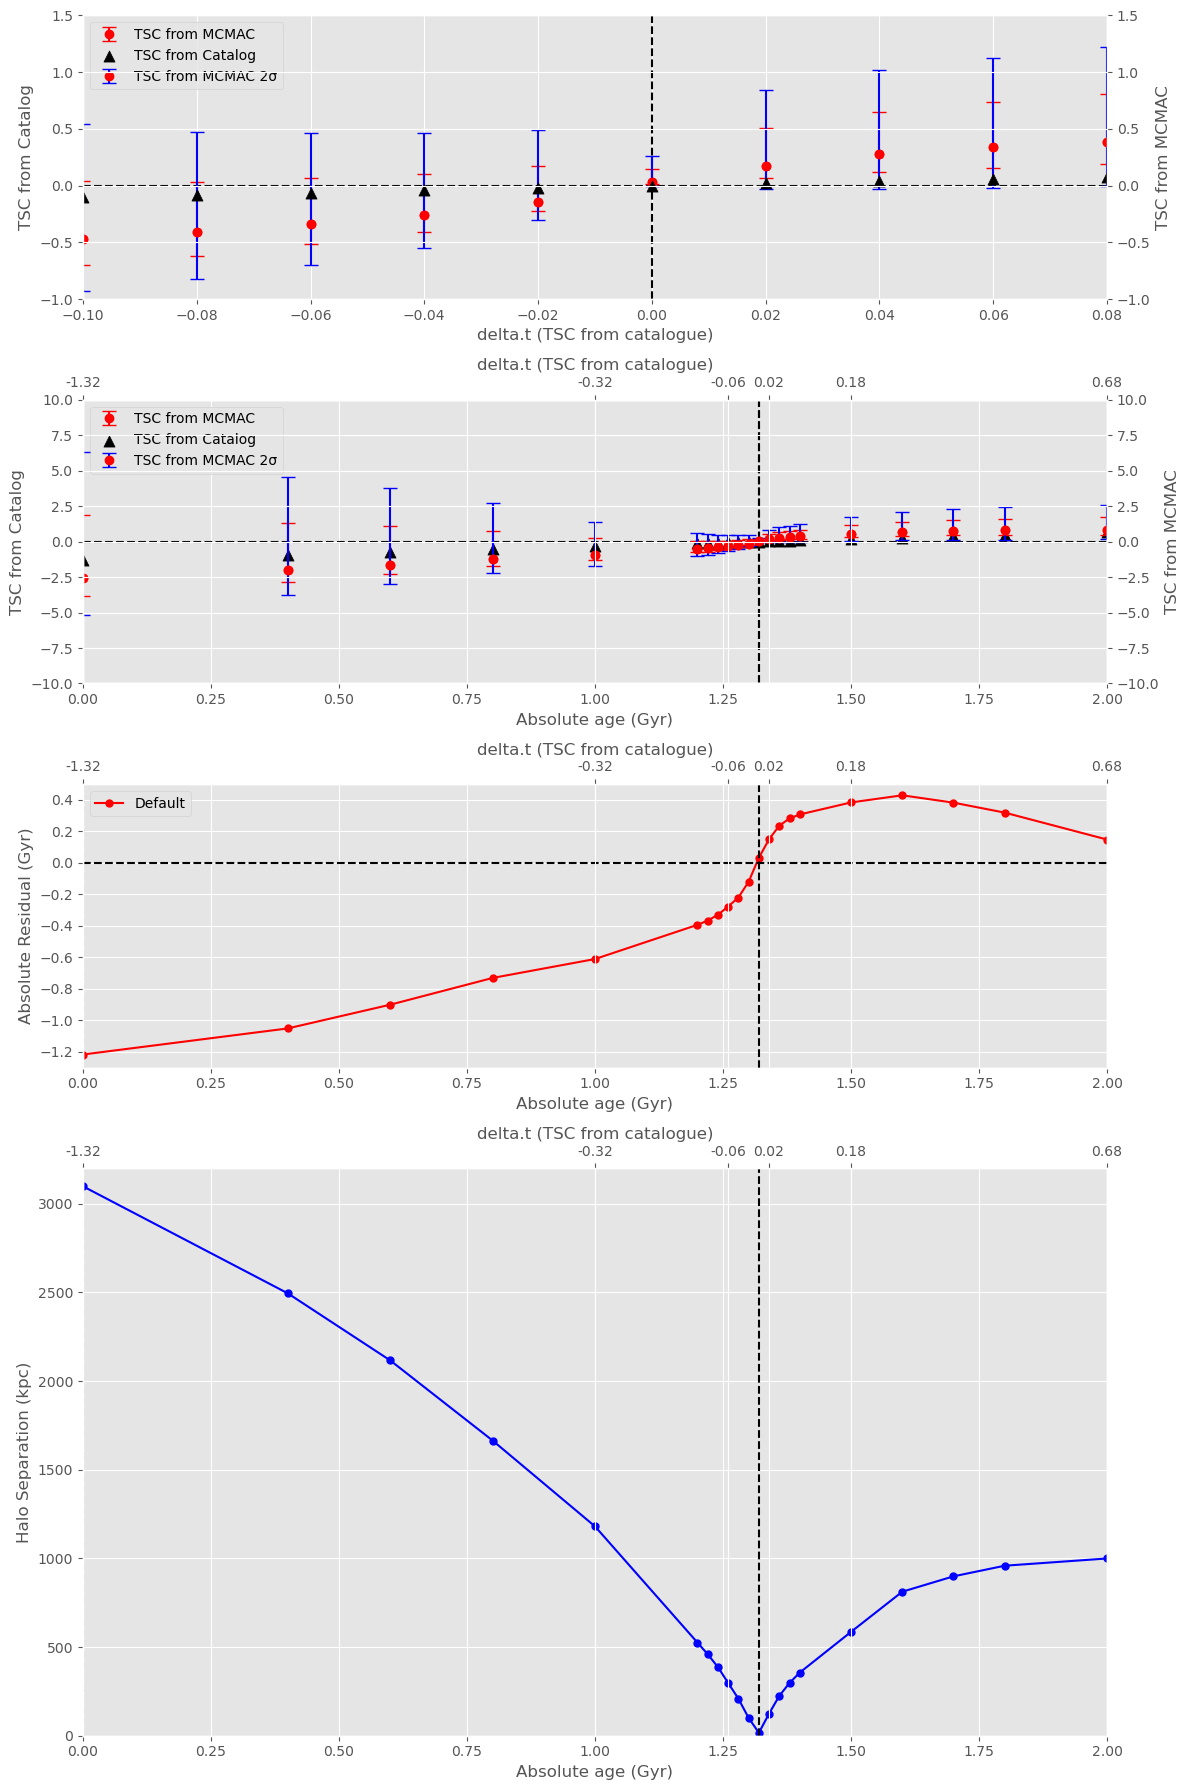

In [155]:
filename_default = '../output_default/zh_1to1_b0_z_MCMAC.txt'

zoom_x_range = [-0.1, 0.08]
zoom_y_range = [-1, 1.5]
plot1_x_range = [0, 2]
plot1_y_range = [-10, 10]
plot2_x_range = [0, 2]
plot2_y_range = [-1.3, 0.5]
plot3_x_range = [0, 2]
plot3_y_range = [0, 3200]
absolute_merge_time = 2 - 0.68

plotImage(filename_default,zoom_x_range, zoom_y_range, plot1_x_range, plot1_y_range, plot2_x_range, plot2_y_range, plot3_x_range, plot3_y_range, absolute_merge_time)

## Mass ratio 1:1 b=500kpc

/tmp/ipykernel_1227147/1057079977.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_default['TSC0_2sigma.lower'] = df_selected_default['TSC0'] - 2 * np.abs(df_selected_default['TSC0'] - df_selected_default['TSC0.lower'])
/tmp/ipykernel_1227147/1057079977.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_default['TSC0_2sigma.upper'] = df_selected_default['TSC0'] + 2 * np.abs(df_selected_default['TSC0.upper'] - df_selected_default['TSC0'])


2σ covers it
Pearson Correlation Coefficient: 0.98


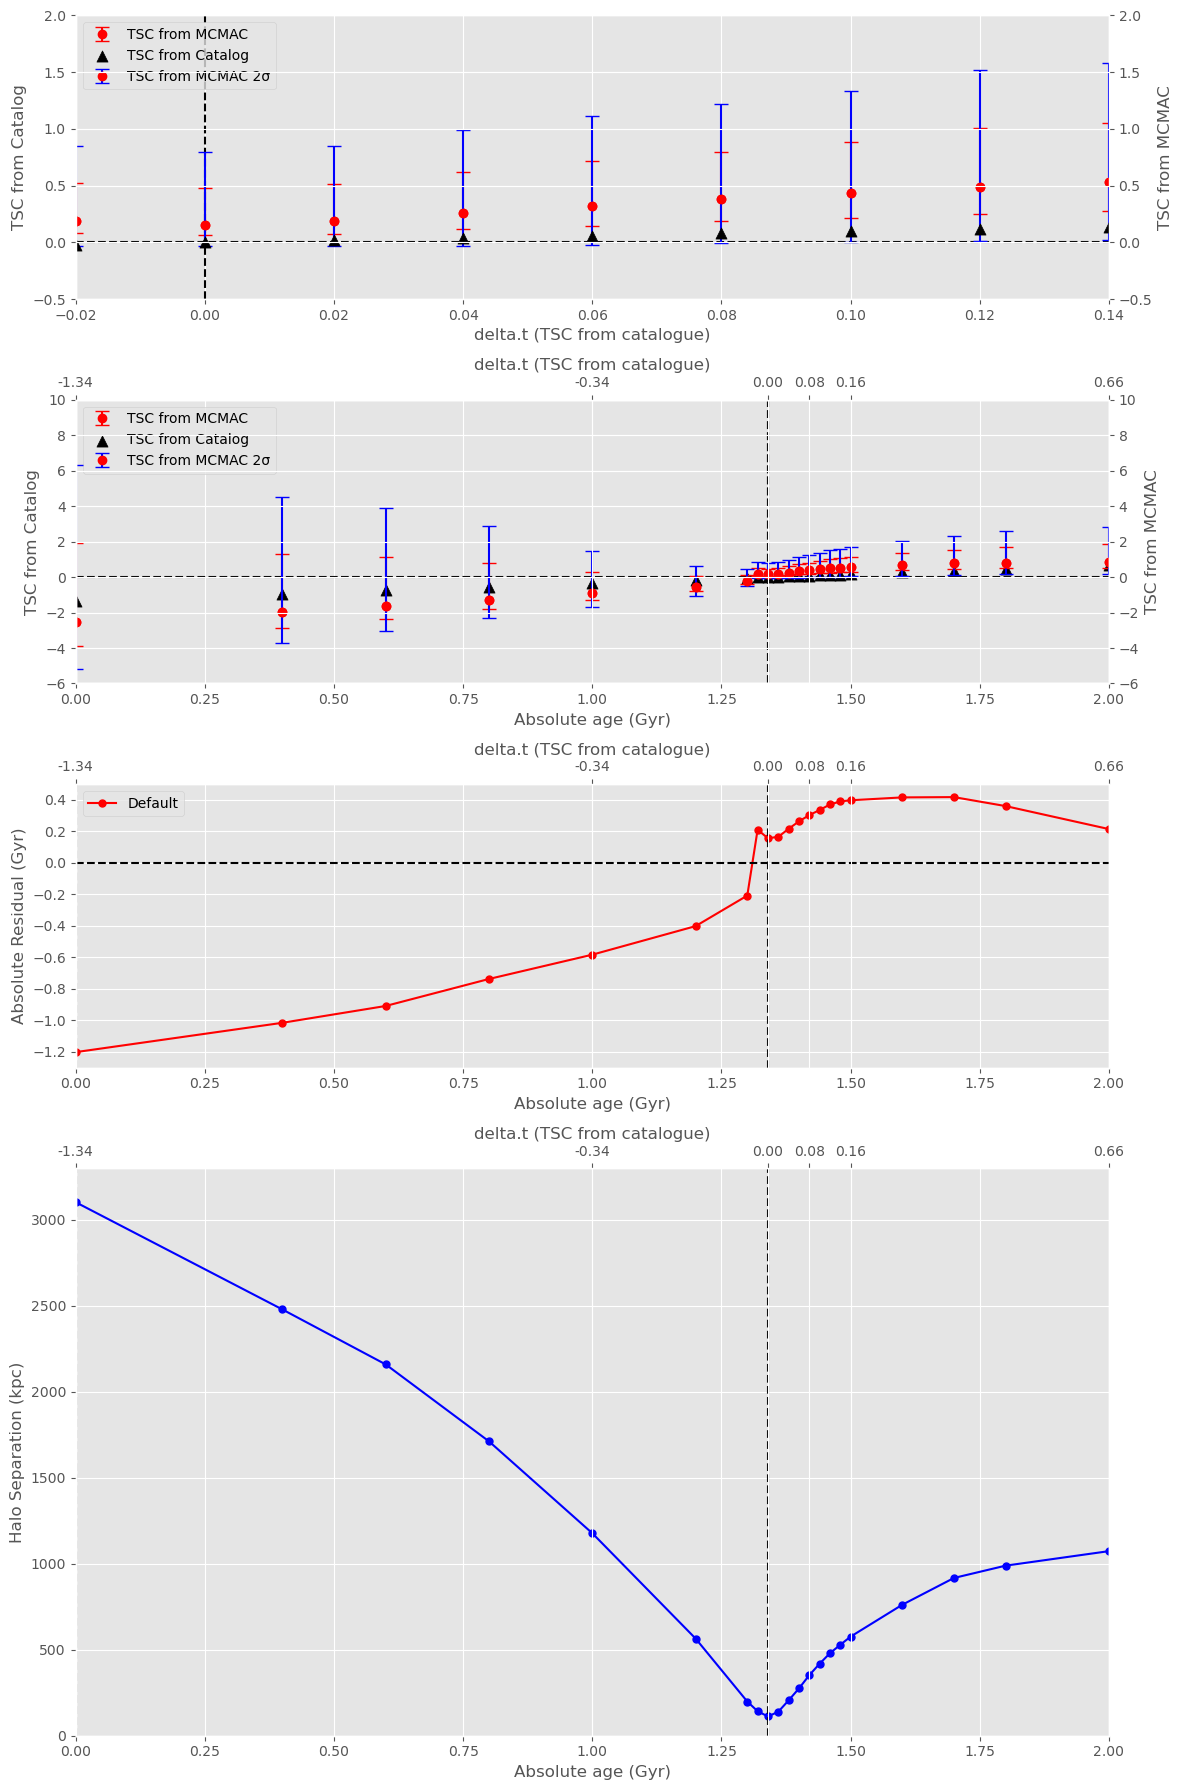

In [156]:
filename_default = '../output_default/zh_1to1_b0.5_z_MCMAC.txt'

zoom_x_range = [-0.02, 0.14]
zoom_y_range = [-0.5, 2]
plot1_x_range = [0, 2]
plot1_y_range = [-6, 10]
plot2_x_range = [0, 2]
plot2_y_range = [-1.3, 0.5]
plot3_x_range = [0, 2]
plot3_y_range = [0, 3300]
absolute_merge_time = 2 - 0.66

plotImage(filename_default, zoom_x_range, zoom_y_range, plot1_x_range, plot1_y_range, plot2_x_range, plot2_y_range, plot3_x_range, plot3_y_range, absolute_merge_time)

## Mass ratio 1:1 b=1000kpc

/tmp/ipykernel_1227147/1057079977.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_default['TSC0_2sigma.lower'] = df_selected_default['TSC0'] - 2 * np.abs(df_selected_default['TSC0'] - df_selected_default['TSC0.lower'])
/tmp/ipykernel_1227147/1057079977.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_default['TSC0_2sigma.upper'] = df_selected_default['TSC0'] + 2 * np.abs(df_selected_default['TSC0.upper'] - df_selected_default['TSC0'])


2σ covers it
Pearson Correlation Coefficient: 0.97


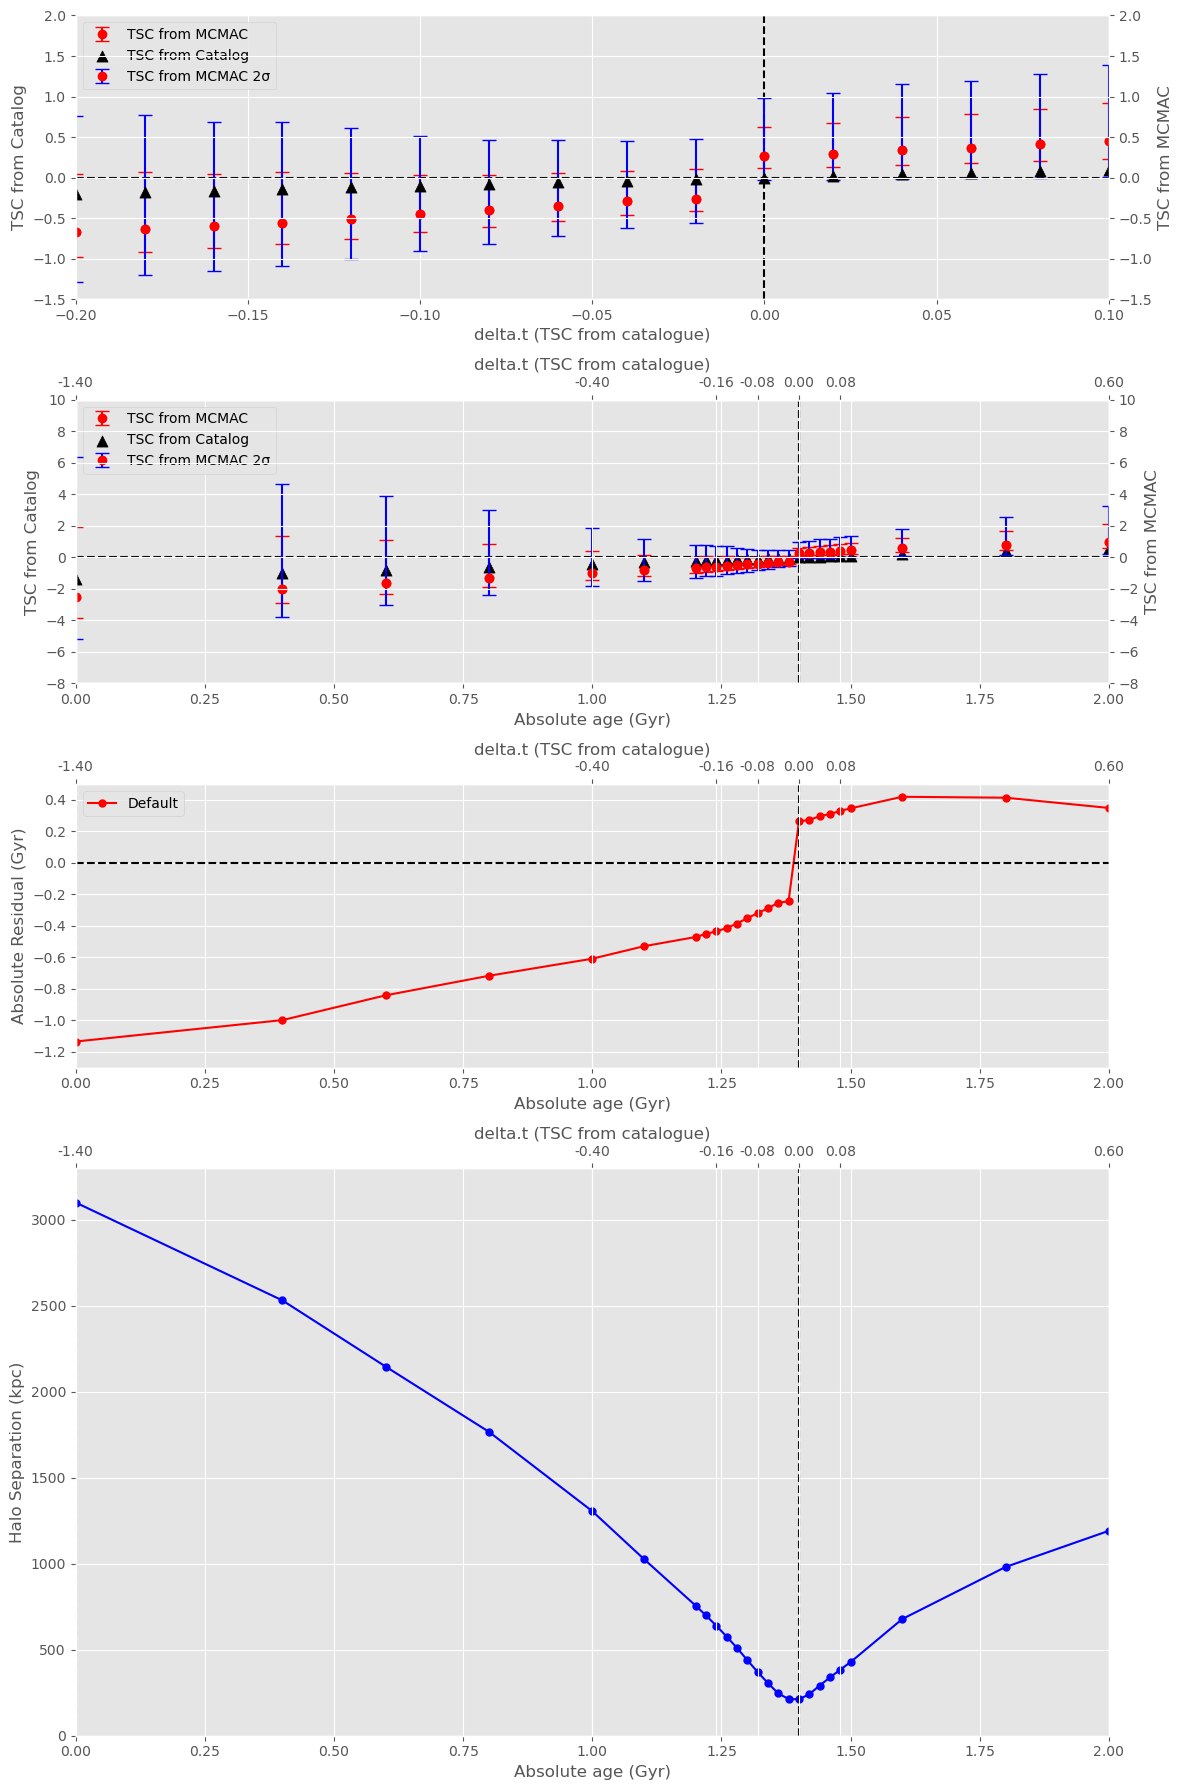

In [157]:
filename_default = '../output_default/zh_1to1_b1_z_MCMAC.txt'

zoom_x_range = [-0.2, 0.1]
zoom_y_range = [-1.5, 2]
plot1_x_range = [0, 2]
plot1_y_range = [-8, 10]
plot2_x_range = [0, 2]
plot2_y_range = [-1.3, 0.5]
plot3_x_range = [0, 2]
plot3_y_range = [0, 3300]
absolute_merge_time = 2 - 0.6

plotImage(filename_default, zoom_x_range, zoom_y_range, plot1_x_range, plot1_y_range, plot2_x_range, plot2_y_range, plot3_x_range, plot3_y_range, absolute_merge_time)

Results for 0-90 degree:


,filename,MAE,RMSE,R²
0,1:1 (b=0),0.422931,0.520465,-0.328451
1,1:1 (b=0.5),0.441105,0.524029,-0.294872
2,1:1 (b=1),0.457273,0.511360,-0.529676


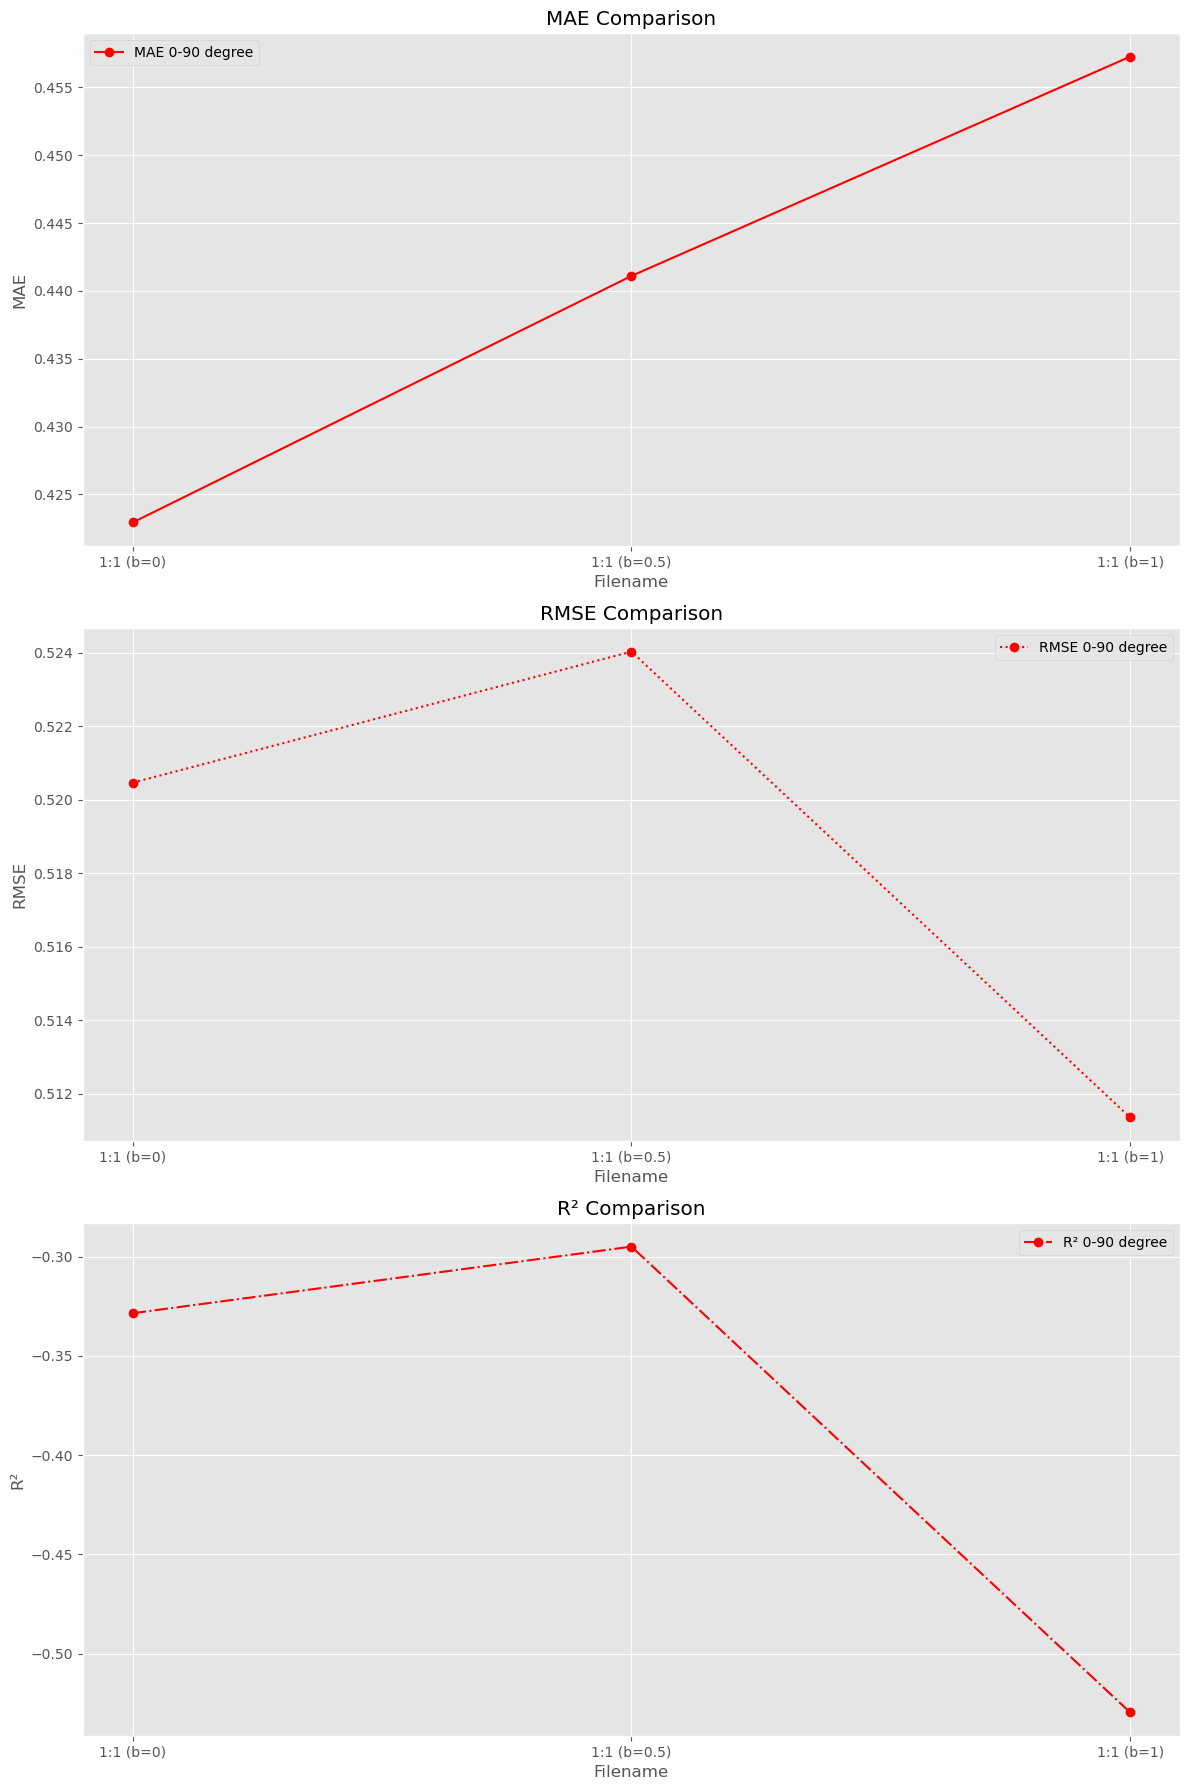

In [158]:
# Convert results lists to dataframes
results_df_0_90 = pd.DataFrame(results_0_90)

# Print the dataframes
print("Results for 0-90 degree:")
display(results_df_0_90)

# プロットの設定
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# MAEのプロット
axs[0].plot(results_df_0_90['filename'], results_df_0_90['MAE'], 'r-', marker='o', label='MAE 0-90 degree')
axs[0].set_title('MAE Comparison')
axs[0].set_xlabel('Filename')
axs[0].set_ylabel('MAE')
axs[0].legend()
axs[0].grid(True)

# RMSEのプロット
axs[1].plot(results_df_0_90['filename'], results_df_0_90['RMSE'], 'r:', marker='o', label='RMSE 0-90 degree')
axs[1].set_title('RMSE Comparison')
axs[1].set_xlabel('Filename')
axs[1].set_ylabel('RMSE')
axs[1].legend()
axs[1].grid(True)

# R²のプロット
axs[2].plot(results_df_0_90['filename'], results_df_0_90['R²'], 'r-.', marker='o', label='R² 0-90 degree')
axs[2].set_title('R² Comparison')
axs[2].set_xlabel('Filename')
axs[2].set_ylabel('R²')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()